# Learning to Rank using XGBoost

This notebook demonstrates how to train a ranking model using [XGBoost](https://xgboost.readthedocs.io/).  

This notebook is part of the [commerce product ranking sample app](https://github.com/vespa-engine/sample-apps/tree/master/commerce-product-ranking).

Blog post series:

* [Improving Product Search with Learning to Rank - part one](https://blog.vespa.ai/improving-product-search-with-ltr/)
* [Improving Product Search with Learning to Rank - part two](https://blog.vespa.ai/improving-product-search-with-ltr-part-two/)
* [Improving Product Search with Learning to Rank - part three](https://blog.vespa.ai/improving-product-search-with-ltr-part-three/)

This work uses the largest product relevance dataset released by Amazon:

>We introduce the “Shopping Queries Data Set”, a large dataset of difficult search queries, released with the aim of fostering research in the area of semantic matching of queries and products. For each query, the dataset provides a list of up to 40 potentially relevant results, together with ESCI relevance judgements (Exact, Substitute, Complement, Irrelevant) indicating the relevance of the product to the query. Each query-product pair is accompanied by additional information. The dataset is multilingual, as it contains queries in English, Japanese, and Spanish.

The dataset is found at [amazon-science/esci-data](https://github.com/amazon-science/esci-data).
The dataset and is released under the [Apache 2.0 license](https://github.com/amazon-science/esci-data/blob/main/LICENSE).



In [1]:
!pip3 install pandas xgboost numpy

In [2]:
import pandas
import xgboost

Read the published training data. This dataframe contains scraped features from a running Vespa instance, using a  scrape rank-profile, returning calculated features using [match-features](https://docs.vespa.ai/en/reference/schema-reference.html#match-features).

In [27]:
train = pandas.read_parquet('https://data.vespa-cloud.com/sample-apps-data/product_ranking_train.parquet')

## Dataset and split processing
Convert the dataset's textual labels Exact, Substitute, Complement, Irrelevant to numeric labels. XGBoost does not
support custom label gains, so we convert directly to the label gain.

In [77]:
esci_2_numeric = {
        'E' : 20,
        'S' : 5,
        'C' : 1,
        'I' : 0,
}
train['label'] = train['esci_label'].apply(lambda esci_label: esci_2_numeric[esci_label])

In [78]:
train.head(2)

,example_id,query,query_id,product_id,product_locale,esci_label,small_version,large_version,split,bm25(brand),...,max_title_significance,mean_title_significance,term(0).significance,term(1).significance,term(2).significance,term(3).significance,term(4).significance,textSimilarity(title).order,textSimilarity(title).proximity,label
0,16,!awnmower tires without rims,1,B075SCHMPY,us,I,1,1,train,0.0,...,1.0,0.746949,1.0,0.694141,0.588769,0.704887,0.5,0.0,0.0000,0
1,17,!awnmower tires without rims,1,B08L3B9B9P,us,E,1,1,train,0.0,...,1.0,0.746949,1.0,0.694141,0.588769,0.704887,0.5,1.0,0.9375,20


We create a dev split from the original train split (80:20 split)

In [79]:
train_queries = pandas.read_parquet('https://data.vespa-cloud.com/sample-apps-data/train_query_ids.parquet')['query_id'].unique()
dev_queries = pandas.read_parquet('https://data.vespa-cloud.com/sample-apps-data/dev_query_ids.parquet')['query_id'].unique()

We filter so that we end up with two splits or the original train dataset. This way we can evaluate performance on the dev set and we avoid tuning hyperparameters based on observed test set performance.

In [80]:
df_train = train[train['query_id'].isin(train_queries)]
df_dev = train[train['query_id'].isin(dev_queries)]

We need to group by query_id so that XGBoost knows which products belongs to which query.

In [81]:
train_query_groups=df_train['query_id'].value_counts().sort_index().values
dev_query_groups=df_dev['query_id'].value_counts().sort_index().values

The label we want to predict  

In [82]:
train_target = df_train['label'].values
dev_target = df_dev['label'].values

Drop columns that we don't need during training, after this we are left with just the pure features

In [83]:
drop_fields = ['example_id', 'query', 'query_id', 'product_id', 'product_locale', 'esci_label', 'small_version', 'large_version', 'split', 'label']


In [84]:
df_dev = df_dev.drop(drop_fields, axis=1)
df_train = df_train.drop(drop_fields, axis=1)

In this case, we choose a subset of features to train with. Deleting this cell, trains on all available features.

In [85]:
keep_features = ['bi_encoder', 'bm25(title)', 'bm25(description)', 'bm25(bullets)', 'nativeRank(title)']
df_dev = df_dev[keep_features]
df_train = df_train[keep_features]

In [86]:
df_train.head(2)

,bi_encoder,bm25(title),bm25(description),bm25(bullets),nativeRank(title)
0,0.468920,4.984932,14.295459,13.659327,0.030665
1,0.480936,10.470566,17.009160,10.367830,0.065069


## Prepare for training the model
Create xgboost DMatrix of the train and dev splits. Please notice the set_group calls,
so that the xgboost knows which data points belongs to which query.

In [87]:
train_ds = xgboost.DMatrix(df_train, train_target)
train_ds.set_group(train_query_groups)
dev_ds = xgboost.DMatrix(df_dev, dev_target)
dev_ds.set_group(dev_query_groups)

## Model Training

Configure hyperparameters. We set `base_score` to 0 as the XGBoost export routine does not include the `base_score` bias. Vespa assumes that `base_score` is 0.

We use `rank:ndcg` objective, see [XGBoost objectives](https://xgboost.readthedocs.io/en/stable/parameter.html#learning-task-parameters)

Relevant ranking objectives:
- `rank:ndcg` listwise loss
- `rank:pairwise` pairwise loss

The ranking objective does not change how we do inference with the model, only how the model is trained.

In [88]:
params = {
    'objective': 'rank:ndcg',
    'eval_metric': ['ndcg@10'],
    'verbosity': 1,
    'booster': 'gbtree',
    'base_score': 0,
    'eta': 0.05,
    'max_depth': 8
}

Train the model, output's NDCG for both the train and our dev split. We use `early_stopping_rounds=50`, which will stop training if the `dev` dataset NDCG metric does not improve.

In [89]:
model = xgboost.train(
    params, train_ds, evals=[(train_ds, 'train'), (dev_ds, 'dev')],
    num_boost_round=1000,
    early_stopping_rounds=20
)

[0]	train-ndcg@10:0.73101	dev-ndcg@10:0.69836
[1]	train-ndcg@10:0.73978	dev-ndcg@10:0.70348
[2]	train-ndcg@10:0.74249	dev-ndcg@10:0.70548
[3]	train-ndcg@10:0.74368	dev-ndcg@10:0.70637
[4]	train-ndcg@10:0.74566	dev-ndcg@10:0.70667
[5]	train-ndcg@10:0.74626	dev-ndcg@10:0.70603
[6]	train-ndcg@10:0.74715	dev-ndcg@10:0.70620
[7]	train-ndcg@10:0.74807	dev-ndcg@10:0.70672
[8]	train-ndcg@10:0.74951	dev-ndcg@10:0.70705
[9]	train-ndcg@10:0.75002	dev-ndcg@10:0.70708
[10]	train-ndcg@10:0.75071	dev-ndcg@10:0.70705
[11]	train-ndcg@10:0.75128	dev-ndcg@10:0.70784
[12]	train-ndcg@10:0.75144	dev-ndcg@10:0.70740
[13]	train-ndcg@10:0.75205	dev-ndcg@10:0.70807
[14]	train-ndcg@10:0.75250	dev-ndcg@10:0.70789
[15]	train-ndcg@10:0.75287	dev-ndcg@10:0.70807
[16]	train-ndcg@10:0.75340	dev-ndcg@10:0.70788
[17]	train-ndcg@10:0.75343	dev-ndcg@10:0.70784
[18]	train-ndcg@10:0.75392	dev-ndcg@10:0.70755
[19]	train-ndcg@10:0.75427	dev-ndcg@10:0.70749
[20]	train-ndcg@10:0.75439	dev-ndcg@10:0.70743
[21]	train-ndcg@10:0.75

Plot feature importance

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

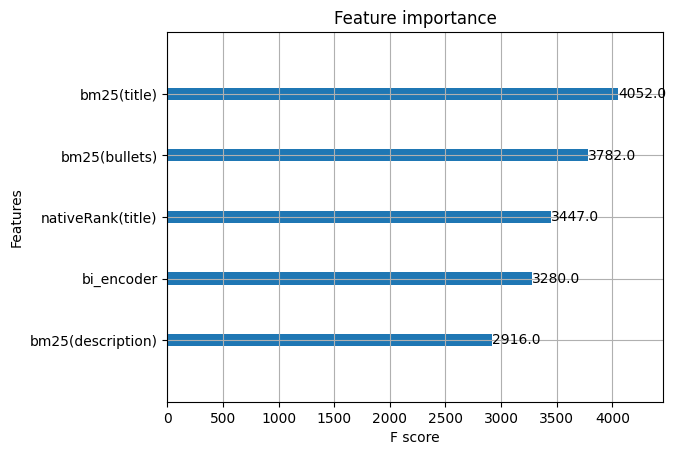

In [90]:
from xgboost import plot_importance
plot_importance(model, max_num_features=10, importance_type='weight')

## Export model for serving in Vespa

See [importing-xgboost models](https://docs.vespa.ai/en/xgboost#exporting-models-from-xgboost) for how to import the exported JSON file into Vespa for serving. Since we used a DataFrame with column names as input, the column names are used as feature names.

In [91]:
model.dump_model('product_ranker_simple_xgboost.json', with_stats=False, dump_format='json')

In [92]:
import json
with open('product_ranker_simple_xgboost.json', 'r') as f:
    model_json = json.load(f)


Only the first 71 trees are exported (as we used early stopping). This is important as number of trees does impact inference performance.

In [94]:
len(model_json)

71

Place the exported `product_ranker_simple.json` file in the `models` directory in the Vespa application package and configure the rank-profile:

<pre>
rank-profile gbdt-small {
  first-phase {
    expression: xgboost("product_ranker_simple_xgboost.json")
  }
}
</pre>